In [1]:
# import the necessary packages
%matplotlib inline

from pyimagesearch.transform import four_point_transform, order_points
from pyimagesearch import imutils
from input_utils import showImg, get_images, crop, expand_rect
import numpy as np
from PIL import Image as Pim
from PIL import ImageOps
from os import listdir
from os.path import isfile, join
import pandas as pd
import json
from pprint import pprint



import math
import cv2

import matplotlib.pyplot as plt
from IPython.display import display, Image
from glob import glob

In [2]:
def mask_for_blue(frame):
    # Convert BGR to HSV
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    # define range of blue color in HSV
    lower_blue = np.array([110,50,50])
    upper_blue = np.array([135,250,245])

    # Threshold the HSV image to get only blue colors
    mask = cv2.inRange(hsv, lower_blue, upper_blue)
    
    new_mask = cv2.GaussianBlur(mask, (9, 9),3)
    new_mask = cv2.inRange(new_mask, 200, 255)

    
    # Bitwise-AND mask and original image
    res = cv2.bitwise_and(frame,frame, mask= mask)

    #cv2.imshow('frame',frame)
    #cv2.imshow('mask',mask)
    #cv2.imshow('res',res)
    #k = cv2.waitKey(50) & 0xFF 
    #if k == 27:
    #    cv2.destroyAllWindows()
    #    cv2.waitKey(1)
    #cv2.waitKey(1)
    return res, new_mask

def blob_detector_ex (img):

    # Read image
    #im = cv2.imread("blob.jpg")
    im = img
    im = cv2.GaussianBlur(im, (3, 3),1)
    
    # Set up the SimpleBlobdetector with default parameters.
    params = cv2.SimpleBlobDetector_Params()
     
    # Change thresholds
    params.minThreshold = 100;
    params.maxThreshold = 256;
     
    # Filter by Area.
    params.filterByArea = True
    params.minArea = 50
     
    # Filter by Circularity
    params.filterByCircularity = False
    params.minCircularity = 0.1
     
    # Filter by Convexity
    params.filterByConvexity = False
    #params.minConvexity = 0.5
     
    # Filter by Inertia
    params.filterByInertia =False
    params.minInertiaRatio = 0.5
    
    # Set up the detector with set parameters.
    detector = cv2.SimpleBlobDetector_create(params)
     
    # Detect blobs.
    reversemask = 255 - im
    keypoints = detector.detect(reversemask)
     
    # Draw detected blobs as red circles.
    # cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle corresponds to the size of blob
    im_with_keypoints = cv2.drawKeypoints(im, keypoints, np.array([]), (0,0,255), 
                                           cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    return keypoints, im_with_keypoints

def snapshots():
    cam = cv2.VideoCapture(0)
    cv2.namedWindow("test")
    img_counter = len(listdir('frames9'))
    
    images = []
    while True:
        ret, frame = cam.read()
        cv2.imshow("test", frame)
        if not ret:
            break
        k = cv2.waitKey(1)
    
        if k%256 == 27:
            # ESC pressed
            print("Escape hit, closing...")
            
            break
            
        elif k%256 == 32:
            # SPACE pressed
            img_name = "frames9/{}.png".format(img_counter)
            
            
            #cv2.putText("test", text, (0,0), fontFace, fontScale, thickness)
            cv2.imwrite(img_name, frame)
            images.append(frame)
            
            print("{} written!".format(img_name))
            img_counter += 1
    
    cam.release()
    
    cv2.destroyAllWindows()
    cv2.waitKey(1)
    return images

def pipeline(images, dim=6):
    rects = []
    imgs = []
    for frame in images:
        res, mask = mask_for_blue(frame)
        showImg(res,8)
        showImg(mask, 8, cv2.COLOR_GRAY2RGB)
        
        #get pnts
        keypoints, im_with_keypoints = blob_detector_ex(mask)
        pt_list = [keypoint.pt for keypoint in keypoints]
        pts = np.asarray(pt_list)
        
        # perfrom scanner transform
        warped = four_point_transform(frame,pts,True)
        
        # crop
        cropped = warped
        #cropped = crop(warped, 13, 15, 12, 12)
        
        # get closer contour
        gray = cv2.cvtColor(cropped,cv2.COLOR_BGR2GRAY)
        gray = cv2.inRange(gray, 105, 255)
        
        kernel = np.ones((5,5),np.uint8)
        erosion = cv2.erode(gray,kernel,iterations = 1)
        gray = cv2.GaussianBlur(erosion, (5, 5),0)
        
        im2, contours, hierarchy = cv2.findContours(gray.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        cnts = sorted(contours, key = cv2.contourArea, reverse = True)[:5]
        
        c = cnts[1]
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.10 * peri, True)
            
        im_cnts2 = cropped.copy()
        blah2 = cv2.drawContours(im_cnts2, [approx], -1, (0,255,0), 3)
        showImg(blah2)
        
        approx.resize(4,2)
        rect = order_points(approx) # UL, UR, BR, BL
        dist = int((rect[1][0] - rect[0][0])/ (dim - 1))
        rect = expand_rect(int(dist/2), rect)
        warped_gray = four_point_transform(gray,rect,True)
        warped_color = four_point_transform(cropped,rect,True)
        
        #showImg(warped_gray, 3, cv2.COLOR_GRAY2RGB)
        showImg(warped_color, 3)
        imgs.append(warped_color)
        rects.append(rect)
    return rects, imgs

def splitPieces(arr, index=0):
    im = Pim.fromarray(arr)
    
    #im = PImage.open(warped_gray)
    dist = int(im.size[0]/dim)
    pad = int(dist/6) 
    
    im = ImageOps.expand(im,50, (200,200,200))
    #im.show()
    crops = np.empty([dim,dim],dtype=Pim.Image)
    for x in range(dim):
        for y in range(dim):
            area = x*dist-pad+50, y*dist-pad+50, x*dist + pad+dist+50, y*dist +pad+50+dist
            crops[x][y] = im.crop(area)
            crops[x][y] = crops[x][y].resize((151, 151), Pim.ANTIALIAS)
            #crops[x][y].show()
            #showImg(np.asarray(crops[x][y]), 2)
            crops[x][y].save('goTiles/' + str(index) +'-('+str(x)+'.'+str(y)+').png')
    return crops

In [ ]:
images = get_images('./frames9', stack=False)
for image in images:
    showImg(image, 3)
print(len(images))

frames9/6.png written!
Escape hit, closing...


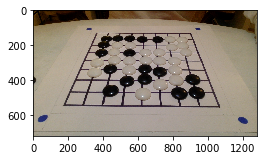

In [3]:
images = snapshots()
for image in images:
    showImg(image, 4)

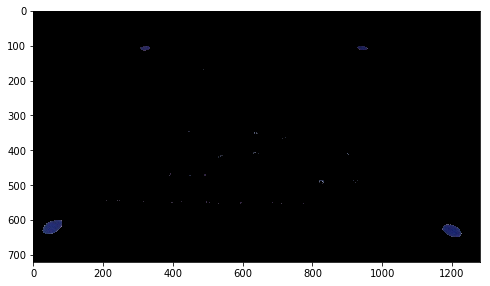

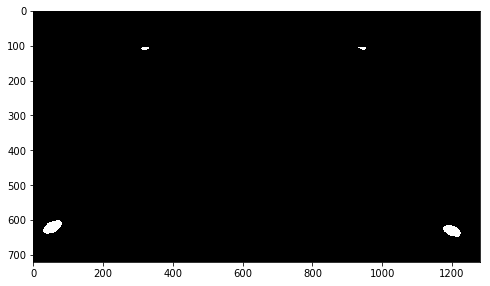

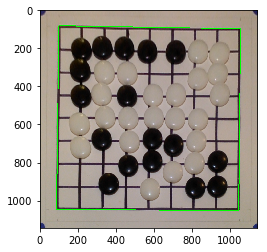

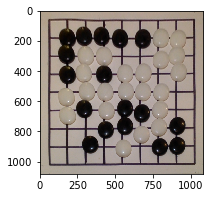

In [4]:
dim = 9
rects, imgs = pipeline(images, dim)

Outline of flow:
    setup camera
    take image
    identify blob coords
    pass coords to transform
    refine image 
        - 
    divide image into 13x13 (or 9x9, etc)
    determine if center is black, white or cross
    make matrix of -1,0,1 for black, none, white piece
    

In [5]:
i = 5
bigcrops = []
for img in imgs:
    bigcrops.append(splitPieces(img,i))
    i += 1
    print(i)

6


In [ ]:
### create y labels
# 1 black, 2 none, 3 white
#showImg(imgs[0],1)
#showImg(np.asarray(crops[1,2])) # looks good for indexing ! 
# img3key = np.asarray([[2,2,2,2,2,2],  ALL 2's example
#                      [2,2,2,2,2,2],
#                      [2,2,2,2,2,2],
#                      [2,2,2,2,2,2],
#                      [2,2,2,2,2,2],
#                      [2,2,2,2,2,2]])
img0key = np.asarray([[2,2,2,2,2,2],
                      [2,2,2,2,2,2],
                      [2,3,1,2,1,2],
                      [2,1,3,1,2,2],
                      [2,2,3,2,3,2],
                      [2,2,2,2,2,2]])
print('img0key mean:',img0key.mean())
img0key.resize(36,)

#showImg(imgs[1])
img1key = np.asarray([[2,2,2,2,2,2],
                      [2,2,2,2,2,2],
                      [2,3,1,1,1,2],
                      [2,1,2,3,2,2],
                      [2,2,3,2,3,2],
                      [2,2,2,2,2,2]])
print('img1key mean:',img1key.mean()) # 4 and 4 black, so should average to none, ie number 2
img1key.resize(36,)

#showImg(imgs[2])
img2key = np.asarray([[2,2,2,2,2,2],
                      [2,1,2,3,2,2],
                      [2,1,2,2,1,2],
                      [2,1,3,3,2,2],
                      [2,2,2,2,3,2],
                      [2,2,2,2,2,2]])
img2key.resize(36,)
print('img2key mean:',img2key.mean()) # 4 and 4 black, so should average to none, ie number 2

#showImg(imgs[3])
img3key = np.asarray([[2,2,2,2,2,2],
                      [1,2,2,1,2,2],
                      [1,2,3,3,2,2],
                      [2,3,2,2,2,2],
                      [2,1,2,2,3,2],
                      [2,2,2,2,2,2]])
img3key.resize(36,)
print('img3key mean:',img3key.mean()) # 4 and 4 black, so should average to none, ie number 2

key = np.concatenate([img0key,img1key,img2key,img3key])
print("key.shape =",key.shape)
np.savetxt("key6_6.csv", key, delimiter=",")


In [8]:
cv2.imwrite('frames9/4.png',images[0])

True

In [9]:
#rawkey0 = np.genfromtxt('rawkey0.csv', delimiter=',')
rawkey0 = pd.read_csv('rawkey0.csv', ',')
rawkey1 = pd.read_csv('rawkey1a.csv', ',')
rawkey2 = pd.read_csv('rawkey2.csv', ',')



print("key.shape =",rawkey1.shape)
print("key.shape =",rawkey2.shape)

black_files = np.array(rawkey1[rawkey1['file_attributes'] == 1]['filename'])
white_files = np.array(rawkey1[rawkey1['file_attributes'] == 3]['filename'])
none_files =  np.array(rawkey1[rawkey1['file_attributes'] == 2]['filename'])


print(len(black_tiles), len (white_files), len(none_files))


black_tiles = [cv2.imread('goTiles/'+file) for file in black_files]
white_tiles = [cv2.imread('goTiles/'+file) for file in white_files]
none_tiles  = [cv2.imread('goTiles/'+file) for file in none_files]

#for im in white_tiles:
 #   showImg(im,2)
    


key.shape = (243, 2)
key.shape = (81, 2)


NameError: name 'black_tiles' is not defined

In [ ]:
## save list of tiles in data folder
for n in range(len(black_tiles)):
    cv2.imwrite('data/black/'+black_files[n], black_tiles[n])
for n in range(len(white_tiles)):
    cv2.imwrite('data/white/'+white_files[n], white_tiles[n])
for n in range(len(none_tiles)):
    cv2.imwrite('data/none/'+none_files[n], none_tiles[n])

In [11]:
## validation set
black_files = np.array(rawkey2[rawkey2['file_attributes'] == 1]['filename'])
white_files = np.array(rawkey2[rawkey2['file_attributes'] == 3]['filename'])
none_files =  np.array(rawkey2[rawkey2['file_attributes'] == 2]['filename'])


print(len(black_files), len (white_files), len(none_files))


black_tiles = [cv2.imread('goTiles/'+file) for file in black_files]
white_tiles = [cv2.imread('goTiles/'+file) for file in white_files]
none_tiles  = [cv2.imread('goTiles/'+file) for file in none_files]

for n in range(len(black_tiles)):
    cv2.imwrite('data/test/black/'+black_files[n], black_tiles[n])
for n in range(len(white_tiles)):
    cv2.imwrite('data/test/white/'+white_files[n], white_tiles[n])
for n in range(len(none_tiles)):
    cv2.imwrite('data/test/none/'+none_files[n], none_tiles[n])

17 22 42


In [ ]:
tiles = get_images('./goTiles')
#print(len(tiles))
showImg(tiles[230])
#print(tiles[0].shape)

X = np.stack(tiles)
# beware images of wrong dim hiding in folder...
print(X.shape)


In [ ]:
## sort images into class directories
black_inds = np.argwhere(keys==1)

black_inds = black_inds.reshape(black_inds.shape[0],)
black_tiles = np.take(tiles,black_inds)

white_inds = np.argwhere(keys==3)
white_inds = white_inds.reshape(white_inds.shape[0],)
white_tiles = np.take(tiles,white_inds)

empty_inds = np.argwhere(keys==2)
empty_inds = empty_inds.reshape(empty_inds.shape[0],)
empty_tiles = np.take(tiles,empty_inds)
print(empty_inds)
for tile in white_tiles:
    showImg(tile,1)

In [ ]:
# from GoScanner.py
# USAGE
# python goScanner.py --image images/page.jpg

# import the necessary packages
from pyimagesearch.transform import four_point_transform
from pyimagesearch import imutils
from skimage.filters import threshold_adaptive
import numpy as np
import argparse
import cv2



# load the image and compute the ratio of the old height
# to the new height, clone it, and resize it
image = cv2.imread(args["image"])
ratio = image.shape[0] / 500.0
orig = image.copy()
image = imutils.resize(image, height = 500)

warped = four_point_transform(orig, screenCnt.reshape(4, 2) * ratio)

# convert the image to grayscale, blur it, and find edges
# in the image
#gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#gray = cv2.GaussianBlur(gray, (5, 5), 0)
#edged = cv2.Canny(gray, 75, 200)

# show the original image and the edge detected image
#print ("STEP 1: Edge Detection")
#cv2.imshow("Image", image)
#cv2.imshow("Edged", edged)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

# find the contours in the edged image, keeping only the
# largest ones, and initialize the screen contour
#_2, cnts, _ = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
#cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]

# loop over the contours
#for c in cnts:
#	# approximate the contour
#	peri = cv2.arcLength(c, True)
#	approx = cv2.approxPolyDP(c, 0.02 * peri, True)
#
#	# if our approximated contour has four points, then we
#	# can assume that we have found our screen
#	if len(approx) == 4:
#		screenCnt = approx
#		break

# show the contour (outline) of the piece of paper
#print ("STEP 2: Find contours of paper")
#cv2.drawContours(image, [screenCnt], -1, (0, 255, 0), 2)
#cv2.imshow("Outline", image)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

# apply the four point transform to obtain a top-down
# view of the original image
#warped = four_point_transform(orig, screenCnt.reshape(4, 2) * ratio)

# convert the warped image to grayscale, then threshold it
# to give it that 'black and white' paper effect
#warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
#warped = threshold_adaptive(warped, 251, offset = 10)
#warped = warped.astype("uint8") * 255

# show the original and scanned images
#print ("STEP 3: Apply perspective transform")
#cv2.imshow("Original", imutils.resize(orig, height = 650))
#cv2.imshow("Scanned", imutils.resize(warped, height = 650))
#cv2.waitKey(0)

